In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 58.9 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00


Versions: torch 2.8.0+cu126 | pyg 2.7.0 | sklearn 1.6.1 | rdkit 2025.09.1 | numpy 2.0.2
Device: cuda
Loaded 4000 molecules.
Saved split indices → split_indices.json
Split sizes — Train: 2323, Val: 400, Test: 1277
Class balance: Train {0: 1482, 1: 841} Val {0: 57, 1: 343} Test {0: 461, 1: 816}

[Warm-up training]
Epoch 001 | TrainAcc=0.638 | ValAUC=0.493
Epoch 005 | TrainAcc=0.713 | ValAUC=0.645
Epoch 010 | TrainAcc=0.746 | ValAUC=0.646
Epoch 015 | TrainAcc=0.760 | ValAUC=0.651
Epoch 020 | TrainAcc=0.759 | ValAUC=0.661
Epoch 025 | TrainAcc=0.772 | ValAUC=0.674
Epoch 030 | TrainAcc=0.775 | ValAUC=0.670
Epoch 035 | TrainAcc=0.788 | ValAUC=0.682
Epoch 040 | TrainAcc=0.788 | ValAUC=0.682
Epoch 045 | TrainAcc=0.791 | ValAUC=0.685
Epoch 050 | TrainAcc=0.791 | ValAUC=0.687
Saved concept cache → concept_cache.npz

[CW] Fitting on 2323 samples, dim=64...
[CW] Base whitening+rotation fitted.

[CW] Aligning axes by correlation...
[CW] Axis assignment by |corr| completed.
   axis 00 → MolWt        

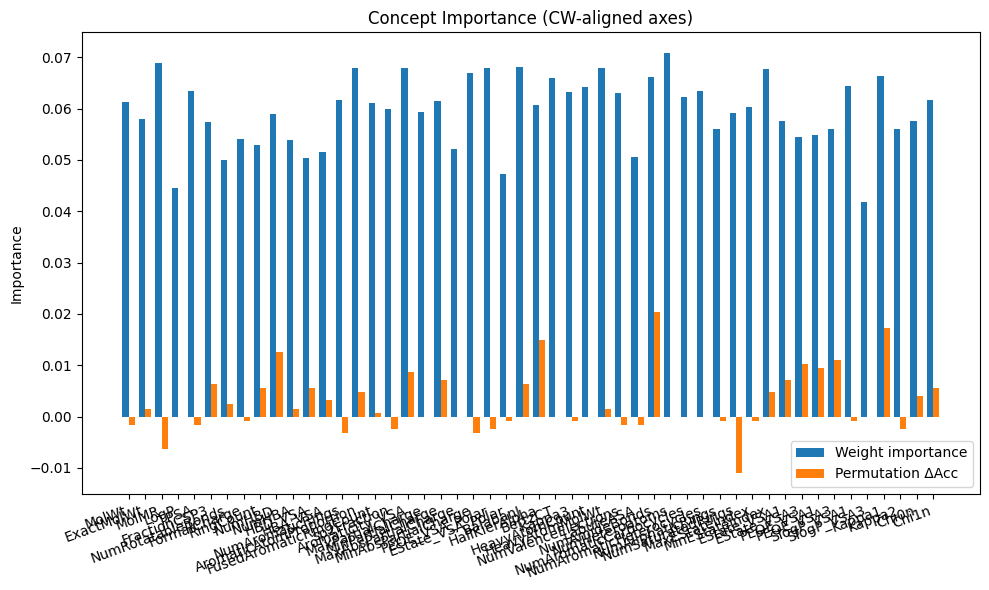


=== Weight-based importance ===
MolWt          : 0.0612
ExactMolWt     : 0.0579
MolMR          : 0.0689
LogP           : 0.0446
TPSA           : 0.0635
FractionCSP3   : 0.0574
NumRotatableBonds: 0.0500
FormalCharge   : 0.0540
RingCount      : 0.0530
NumHBD         : 0.0590
NumHBA         : 0.0538
HBD_VSA        : 0.0503
HBA_VSA        : 0.0514
NumAromaticRings: 0.0617
AromaticAtomProportion: 0.0678
FusedAromaticRingCount: 0.0611
sp2Fraction    : 0.0600
Aromaticity_VSA: 0.0680
MaxPartialCharge: 0.0593
MinPartialCharge: 0.0615
MaxAbsPartialCharge: 0.0520
MinAbsPartialCharge: 0.0670
PEOE_VSA_Polar : 0.0680
EState_VSA_Polar: 0.0472
BalabanJ       : 0.0681
HallKierAlpha  : 0.0607
BertzCT        : 0.0659
Kappa3         : 0.0633
HeavyAtomCount : 0.0643
HeavyAtomMolWt : 0.0679
NumValenceElectrons: 0.0631
LabuteASA      : 0.0506
NumAmideBonds  : 0.0662
NumHeteroatoms : 0.0708
NumAromaticCarbocycles: 0.0622
NumAromaticHeterocycles: 0.0635
NumAliphaticRings: 0.0560
NumSaturatedRings: 0.0592
MaxE

In [ ]:
# -*- coding: utf-8 -*-
# AttentiveFP + Concept Whitening (CW) — publication-ready minimal upgrades
# Deterministic build: env vars + seeds + DataLoader generator + split caching

# =========================
# [A] OS ENV — set BEFORE torch import  <<< DETERMINISM
# =========================
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"   # must be set before torch import
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

# Torch / PyG
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import AttentiveFP
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.data import Batch

# Metrics
import sklearn  # for version print
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix, cohen_kappa_score,
    average_precision_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem import rdPartialCharges
from rdkit.Chem.EState import EStateIndices

# Linear algebra / Hungarian
from sklearn.linear_model import LinearRegression
from scipy.optimize import linear_sum_assignment

# Plot
import matplotlib.pyplot as plt

# =========================
# [B] Config
# =========================
CSV_PATH = "/content/AID1239_data_for_classification_04Nov2024 (4).csv"  # <-- change if needed
SPLIT_TYPE = "scaffold"  # "scaffold" or "random"
RANDOM_SEED = 42

# Model / training params
HIDDEN_CHANNELS = 64
NUM_LAYERS = 4
NUM_TIMESTEPS = 4
DROPOUT = 0.2
LR_WARMUP = 3e-4
LR_FINETUNE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 64

EPOCHS_WARMUP = 50
EPOCHS_FINETUNE_MAX = 200
EARLY_STOP_PATIENCE = 20
ALIGN_EVAL_EVERY = 5

LAMBDA_CONCEPT = 0.0  # set to 0.01–0.05 to softly keep alignment during FT (optional)

# Optional caching paths  <<< CACHE/SPLIT
SPLIT_JSON = "split_indices.json"
CONCEPT_CACHE_NPZ = "concept_cache.npz"

# =========================
# [C] Determinism setup     <<< DETERMINISM
# =========================
def set_seed_all(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed_all()
torch.use_deterministic_algorithms(True)            # raise if non-deterministic op used
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_num_threads(1)


# =========================
# [D] Concept definitions (50)  <<< UPDATED
# =========================
CONCEPT_NAMES = [
    # --- Keep your original 28 (unchanged order) ---
    # A. Physicochemical Core (9)
    "MolWt", "ExactMolWt", "MolMR", "LogP", "TPSA",
    "FractionCSP3", "NumRotatableBonds", "FormalCharge", "RingCount",
    # B. H-bonding & Ionization (4)
    "NumHBD", "NumHBA", "HBD_VSA", "HBA_VSA",
    # C. Aromaticity & Conjugation (5)
    "NumAromaticRings", "AromaticAtomProportion", "FusedAromaticRingCount", "sp2Fraction", "Aromaticity_VSA",
    # D. Electrostatics & Charge (6)
    "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "PEOE_VSA_Polar", "EState_VSA_Polar",
    # E. Topology & 3D Shape (4)
    "BalabanJ", "HallKierAlpha", "BertzCT", "Kappa3",

    # --- Add 22 simple, RDKit-native single scalars ---
    # Physicochemical / counts
    "HeavyAtomCount", "HeavyAtomMolWt", "NumValenceElectrons", "LabuteASA",
    "NumAmideBonds", "NumHeteroatoms",

    # Ring family details
    "NumAromaticCarbocycles", "NumAromaticHeterocycles",
    "NumAliphaticRings", "NumSaturatedRings",

    # EState & VSA bins
    "MaxEStateIndex", "MinEStateIndex",
    "EState_VSA1", "EState_VSA3",
    "PEOE_VSA1", "PEOE_VSA3",
    "SlogP_VSA1", "SlogP_VSA3",

    # Topology
    "Kappa1", "Kappa2",
    "Chi0n", "Chi1n",
]
NUM_CONCEPTS = len(CONCEPT_NAMES)



# =========================
# [E] Featurization (close to AttentiveFP)
# =========================
ATOM_SYMBOLS = ["B","C","N","O","F","Si","P","S","Cl","As","Se","Br","Te","I","At","Metal"]
HYB_ORDER = ["SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"]

def one_hot(value, choices):
    vec = [0]*len(choices)
    idx = choices.index(value) if value in choices else None
    if idx is None: return vec
    vec[idx] = 1
    return vec

def atom_symbol_bucket(atom):
    sym = atom.GetSymbol()
    return sym if sym in ATOM_SYMBOLS[:-1] else "Metal"

def hybrid_bucket(atom):
    hyb = str(atom.GetHybridization()).upper()
    if "SP3D2" in hyb: return "SP3D2"
    if "SP3D"  in hyb: return "SP3D"
    if "SP3"   in hyb: return "SP3"
    if "SP2"   in hyb: return "SP2"
    if "SP"    in hyb: return "SP"
    return "OTHER"

def one_hot_degree(deg):
    d = deg if deg <= 5 else 5
    vec = [0]*6; vec[d] = 1; return vec

def one_hot_hcount(hc):
    h = hc if hc <= 4 else 4
    vec = [0]*5; vec[h] = 1; return vec

def bond_type_one_hot(bond):
    t = bond.GetBondType()
    vec = [0,0,0,0]
    mapping = {Chem.BondType.SINGLE:0, Chem.BondType.DOUBLE:1,
               Chem.BondType.TRIPLE:2, Chem.BondType.AROMATIC:3}
    vec[mapping.get(t,0)] = 1
    return vec

def bond_stereo_one_hot(bond):
    s = bond.GetStereo()
    opts = [Chem.BondStereo.STEREONONE, Chem.BondStereo.STEREOANY,
            Chem.BondStereo.STEREOZ, Chem.BondStereo.STEREOE]
    return one_hot(s, opts)

def mol_to_pyg(smiles: str, label: int) -> Data:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None

    x_list = []
    for atom in mol.GetAtoms():
        sym_vec = one_hot(atom_symbol_bucket(atom), ATOM_SYMBOLS)
        deg_vec = one_hot_degree(atom.GetDegree())
        charge = [atom.GetFormalCharge()]
        radical = [atom.GetNumRadicalElectrons()]
        hyb_vec = one_hot(hybrid_bucket(atom), HYB_ORDER)
        aromatic = [int(atom.GetIsAromatic())]
        hcount_vec = one_hot_hcount(atom.GetTotalNumHs())
        is_chiral_center = [int(atom.HasProp('_CIPCode'))]
        cip = atom.GetProp('_CIPCode') if atom.HasProp('_CIPCode') else ""
        chiral_type = one_hot(cip, ["R","S"])
        node_feat = sym_vec + deg_vec + charge + radical + hyb_vec + \
                    aromatic + hcount_vec + is_chiral_center + chiral_type
        x_list.append(node_feat)
    x = torch.tensor(np.asarray(x_list, dtype=np.float32), dtype=torch.float32)

    ei, ea = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        e = bond_type_one_hot(bond) + [float(bond.GetIsConjugated())] + \
            [float(bond.IsInRing())] + bond_stereo_one_hot(bond)  # 10 dims
        ei.extend([[i,j],[j,i]]); ea.extend([e, e])
    if not ei:
        for idx in range(mol.GetNumAtoms()):
            ei.append([idx, idx]); ea.append([1,0,0,0, 0,0, 1,0,0,0])

    edge_index = torch.tensor(np.asarray(ei).T, dtype=torch.long)
    edge_attr  = torch.tensor(np.asarray(ea, dtype=np.float32), dtype=torch.float32)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.y = torch.tensor([label], dtype=torch.long)
    data.smiles = smiles
    return data

# =========================
# [F] Concepts (50 descriptors)  <<< UPDATED
# =========================
def compute_concepts(smiles_list: List[str]) -> np.ndarray:
    """
    Returns an (N, 50) float32 array in the order of CONCEPT_NAMES.
    Only simple RDKit scalar descriptors; no lists.
    """
    # Feature factory for HBD/HBA VSA (uses BaseFeatures.fdef)
    fdef = os.path.join(RDConfig.RDDataDir, "BaseFeatures.fdef")
    feat_factory = ChemicalFeatures.BuildFeatureFactory(fdef)

    rows = []
    for smi in smiles_list:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            rows.append([np.nan]*NUM_CONCEPTS)
            continue

        # Charges for PEOE-based fields
        try:
            rdPartialCharges.ComputeGasteigerCharges(m)
        except Exception:
            pass

        # Per-atom EState
        try:
            est_idx = EStateIndices(m)
        except Exception:
            est_idx = [0.0]*m.GetNumAtoms()

        # Labute atom areas (no hydrogens)
        try:
            atom_areas = rdMolDescriptors._CalcLabuteAtomContribs(m)[0]
        except Exception:
            atom_areas = [0.0]*m.GetNumAtoms()

        # Helper: VSA sum over a set of atom indices
        def vsa_sum(ids):
            if not ids: return 0.0
            return float(sum(atom_areas[i] for i in ids if 0 <= i < len(atom_areas)))

        # Donor/Acceptor atom indices via features
        feats = feat_factory.GetFeaturesForMol(m)
        donor_ids    = sorted({aid for f in feats if f.GetType()=="Donor"    for aid in f.GetAtomIds()})
        acceptor_ids = sorted({aid for f in feats if f.GetType()=="Acceptor" for aid in f.GetAtomIds()})

        # Aromatic atoms
        aromatic_ids = [a.GetIdx() for a in m.GetAtoms() if a.GetIsAromatic()]

        # Fractions over heavy atoms only
        heavy_atoms = [a for a in m.GetAtoms() if a.GetAtomicNum() > 1]
        heavy_n = max(1, len(heavy_atoms))
        sp2_fraction = sum(int(a.GetHybridization()==Chem.rdchem.HybridizationType.SP2) for a in heavy_atoms) / heavy_n
        aromatic_atom_prop = sum(int(a.GetIsAromatic()) for a in heavy_atoms) / heavy_n

        # Fused aromatic ring count (simple: count pairs sharing ≥2 atoms)
        fused_count = 0
        ri = m.GetRingInfo()
        aro_rings = [tuple(r) for r in ri.AtomRings() if all(m.GetAtomWithIdx(i).GetIsAromatic() for i in r)]
        L = len(aro_rings)
        if L > 1:
            for i in range(L):
                si = set(aro_rings[i])
                for j in range(i+1, L):
                    if len(si.intersection(aro_rings[j])) >= 2:
                        fused_count += 1

        # Formal charge
        formal_charge = float(sum(a.GetFormalCharge() for a in m.GetAtoms()))

        # PEOE_VSA_Polar (simple threshold on |Gasteiger|, sum atom areas)
        g_charges = []
        for a in m.GetAtoms():
            try:
                q = float(a.GetProp("_GasteigerCharge"))
                if not np.isfinite(q): q = 0.0
            except Exception:
                q = 0.0
            g_charges.append(q)
        PEOE_POLAR_THR = 0.2
        peoe_polar_ids = [i for i, q in enumerate(g_charges) if abs(q) >= PEOE_POLAR_THR]

        # EState_VSA_Polar = sum(area * |EState|)
        estate_vsa_polar = 0.0
        for i in range(min(len(atom_areas), len(est_idx))):
            estate_vsa_polar += atom_areas[i] * abs(float(est_idx[i]))

        # Build the 50-element feature row (order = CONCEPT_NAMES)
        row = [
            # --- original 28 ---
            # A. Physicochemical Core (9)
            Descriptors.MolWt(m),
            Descriptors.ExactMolWt(m),
            Descriptors.MolMR(m),
            Descriptors.MolLogP(m),
            rdMolDescriptors.CalcTPSA(m),
            rdMolDescriptors.CalcFractionCSP3(m),
            rdMolDescriptors.CalcNumRotatableBonds(m),
            formal_charge,
            rdMolDescriptors.CalcNumRings(m),

            # B. H-bonding & Ionization (4)
            rdMolDescriptors.CalcNumHBD(m),
            rdMolDescriptors.CalcNumHBA(m),
            vsa_sum(donor_ids),     # HBD_VSA
            vsa_sum(acceptor_ids),  # HBA_VSA

            # C. Aromaticity & Conjugation (5)
            rdMolDescriptors.CalcNumAromaticRings(m),
            aromatic_atom_prop,
            float(fused_count),
            sp2_fraction,
            vsa_sum(aromatic_ids),  # Aromaticity_VSA

            # D. Electrostatics & Charge (6)
            Descriptors.MaxPartialCharge(m),
            Descriptors.MinPartialCharge(m),
            Descriptors.MaxAbsPartialCharge(m),
            Descriptors.MinAbsPartialCharge(m),
            vsa_sum(peoe_polar_ids),   # PEOE_VSA_Polar
            float(estate_vsa_polar),   # EState_VSA_Polar

            # E. Topology & 3D Shape (4)
            Descriptors.BalabanJ(m),
            Descriptors.HallKierAlpha(m),
            Descriptors.BertzCT(m),
            Descriptors.Kappa3(m),

            # --- added 22 simple RDKit scalars ---
            # Physicochemical / counts
            Descriptors.HeavyAtomCount(m),
            Descriptors.HeavyAtomMolWt(m),
            Descriptors.NumValenceElectrons(m),   # safe in Descriptors.*
            Descriptors.LabuteASA(m),
            rdMolDescriptors.CalcNumAmideBonds(m),
            Descriptors.NumHeteroatoms(m),

            # Ring family details
            rdMolDescriptors.CalcNumAromaticCarbocycles(m),
            rdMolDescriptors.CalcNumAromaticHeterocycles(m),
            rdMolDescriptors.CalcNumAliphaticRings(m),
            rdMolDescriptors.CalcNumSaturatedRings(m),

            # EState & VSA bins
            Descriptors.MaxEStateIndex(m),
            Descriptors.MinEStateIndex(m),
            Descriptors.EState_VSA1(m),
            Descriptors.EState_VSA3(m),
            Descriptors.PEOE_VSA1(m),
            Descriptors.PEOE_VSA3(m),
            Descriptors.SlogP_VSA1(m),
            Descriptors.SlogP_VSA3(m),

            # Topology
            Descriptors.Kappa1(m),
            Descriptors.Kappa2(m),
            Descriptors.Chi0n(m),
            Descriptors.Chi1n(m),
        ]

        rows.append([float(x) for x in row])

    return np.asarray(rows, dtype=np.float32)

# ---------------------- END CONCEPT EXTRACTION ----------------------



# =========================
# [G] Dataset loading + splitting (+ optional cached splits)  <<< CACHE/SPLIT
# =========================
def load_csv_make_dataset(csv_path: str) -> Tuple[List[Data], List[str]]:
    df = pd.read_csv(csv_path)
    mapping = {'Active':1,'Inactive':0,'active':1,'inactive':0,'ACTIVE':1,'INACTIVE':0}
    df = df[df['PUBCHEM_ACTIVITY_OUTCOME'].isin(mapping)]
    smiles = df['SMILES'].tolist()
    labels = [mapping[v] for v in df['PUBCHEM_ACTIVITY_OUTCOME']]
    data_list, smiles_clean = [], []
    for smi, y in zip(smiles, labels):
        g = mol_to_pyg(smi, y)
        if g is not None:
            data_list.append(g)
            smiles_clean.append(smi)
    return data_list, smiles_clean

def class_counts(data_list: List[Data]) -> Dict[int, int]:
    ys = [int(d.y.item()) for d in data_list]
    return {0: ys.count(0), 1: ys.count(1)}

def generate_scaffolds(smiles_list: List[str]) -> Dict[str, List[int]]:
    scaff2idx = {}
    for i, smi in enumerate(smiles_list):
        m = Chem.MolFromSmiles(smi)
        scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=m) if m else ""
        scaff2idx.setdefault(scaf, []).append(i)
    return scaff2idx

def scaffold_split_balanced(data: List[Data], smiles: List[str], frac=(0.8, 0.1, 0.1), seed=RANDOM_SEED):
    assert abs(sum(frac) - 1.0) < 1e-6
    rng = np.random.RandomState(seed)
    scaff2idx = generate_scaffolds(smiles)
    buckets = sorted(scaff2idx.values(), key=lambda v: len(v), reverse=True)
    n = len(data); n_train, n_val = int(frac[0]*n), int(frac[1]*n)

    def pick(idxs): return [data[i] for i in idxs], [smiles[i] for i in idxs]
    train_idx, val_idx, test_idx = [], [], []
    train_counts = {0:0, 1:0}; val_counts = {0:0, 1:0}; test_counts = {0:0, 1:0}

    def add_group(target, counts, idxs):
        target.extend(idxs)
        for i in idxs: counts[int(data[i].y.item())] += 1

    for grp in buckets:
        zeros = sum(int(data[i].y.item()) == 0 for i in grp); ones = len(grp) - zeros
        options = []
        for name, idx_list, cnts, cap in [
            ("train", train_idx, train_counts, n_train),
            ("val",   val_idx,   val_counts,   n_val),
            ("test",  test_idx,  test_counts,  n)
        ]:
            if len(idx_list) + len(grp) <= cap:
                z_after = cnts[0] + zeros; o_after = cnts[1] + ones
                options.append((abs(z_after - o_after), name))
        if not options: options = [(0, "test")]
        _, choice = sorted(options)[0]
        if choice == "train": add_group(train_idx, train_counts, grp)
        elif choice == "val": add_group(val_idx, val_counts, grp)
        else: add_group(test_idx, test_counts, grp)

    def has_both(idxs):
        labs = [int(data[i].y.item()) for i in idxs]
        return (0 in labs) and (1 in labs)

    if not (has_both(train_idx) and has_both(val_idx) and has_both(test_idx)):
        labels = [int(d.y.item()) for d in data]
        all_idx = np.arange(len(data))
        tr, te = train_test_split(all_idx, test_size=0.2, stratify=labels, random_state=seed)
        tr_labels = [labels[i] for i in tr]
        tr, va = train_test_split(tr, test_size=0.2, stratify=tr_labels, random_state=seed)
        return pick(tr), pick(va), pick(te)

    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return pick(train_idx), pick(val_idx), pick(test_idx)

def random_split(data: List[Data], smiles: List[str], seed=RANDOM_SEED):
    labels = [int(d.y.item()) for d in data]
    idx_all = np.arange(len(data))
    idx_train, idx_test = train_test_split(idx_all, test_size=0.2, stratify=labels, random_state=seed)
    labels_train = [labels[i] for i in idx_train]
    idx_tr, idx_val = train_test_split(idx_train, test_size=0.2, stratify=labels_train, random_state=seed)
    def pick(idxs): return [data[i] for i in idxs], [smiles[i] for i in idxs]
    return pick(idx_tr), pick(idx_val), pick(idx_test)

# =========================
# [H] Concept Whitening
# =========================
class ConceptWhitening:
    def __init__(self, input_dim, num_concepts, device):
        self.input_dim = input_dim
        self.num_concepts = num_concepts
        self.device = device
        self.mu_t = None
        self.Sigma_inv_root_t = None
        self.R_t = None
        self.concept_scaler = StandardScaler()

    def fit(self, Z: np.ndarray, Yc: np.ndarray):
        print(f"\n[CW] Fitting on {Z.shape[0]} samples, dim={Z.shape[1]}...")
        Yc_scaled = self.concept_scaler.fit_transform(Yc)

        mu = Z.mean(axis=0)
        Zc = Z - mu
        Sigma = np.cov(Zc, rowvar=False) + 1e-4*np.eye(Zc.shape[1])
        vals, vecs = np.linalg.eigh(Sigma)
        vals = np.clip(vals, 1e-6, None)
        Sigma_inv_root = vecs @ np.diag(1.0/np.sqrt(vals)) @ vecs.T
        Zw = Zc @ Sigma_inv_root

        W = np.zeros((Zw.shape[1], self.num_concepts))
        for i in range(self.num_concepts):
            lr = LinearRegression().fit(Zw, Yc_scaled[:, i])
            W[:, i] = lr.coef_

        Qc, _ = np.linalg.qr(W)  # (d x k)
        filler = Zw.shape[1] - self.num_concepts
        if filler > 0:
            np.random.seed(RANDOM_SEED)
            ext = np.random.randn(Zw.shape[1], filler)
            Q_full, _ = np.linalg.qr(np.concatenate([Qc, ext], axis=1))
            R = Q_full
        else:
            R = Qc

        self.mu_t = torch.from_numpy(mu).float().to(self.device)
        self.Sigma_inv_root_t = torch.from_numpy(Sigma_inv_root).float().to(self.device)
        self.R_t = torch.from_numpy(R).float().to(self.device)
        print("[CW] Base whitening+rotation fitted.")

    def transform(self, Z_t):
        """Accepts torch.Tensor or np.ndarray; returns same type."""
        is_numpy = isinstance(Z_t, np.ndarray)
        Z = torch.from_numpy(Z_t).float().to(self.mu_t.device) if is_numpy else Z_t.to(self.mu_t.device).float()
        out = (Z - self.mu_t) @ self.Sigma_inv_root_t @ self.R_t
        return out.detach().cpu().numpy() if is_numpy else out

    def align_axes_by_corr(self, Z_train, Yc_train, concept_names):
        """
        Align first K whitened axes to concepts by maximizing |corr|.
        """
        K = self.num_concepts
        assert K <= self.input_dim, "num_concepts must be <= input_dim"

        Zt = torch.from_numpy(Z_train).float().to(self.device) if isinstance(Z_train, np.ndarray) else Z_train.to(self.device).float()
        with torch.no_grad():
            Zc = self.transform(Zt)[:, :K].detach().cpu().numpy()

        Ys = self.concept_scaler.transform(np.asarray(Yc_train, dtype=np.float64))

        def _colwise_fix(a):
            a = np.asarray(a, dtype=np.float64)
            mask = np.isfinite(a)
            if mask.all(): return a
            med = np.nanmedian(np.where(mask, a, np.nan), axis=0)
            med = np.where(np.isfinite(med), med, 0.0)
            return np.where(mask, a, med)

        Zc = _colwise_fix(Zc); Ys = _colwise_fix(Ys)

        def _zscore_cols(a, eps=1e-12):
            a = a - np.mean(a, axis=0, keepdims=True)
            std = np.std(a, axis=0, ddof=1, keepdims=True)
            std = np.where(std < eps, eps, std)
            return a / std

        Zc_z = _zscore_cols(Zc); Ys_z = _zscore_cols(Ys)
        C = Zc_z.T @ Ys_z
        C = np.where(np.isfinite(C), C, 0.0)

        row, col = linear_sum_assignment(-np.abs(C))

        P = np.zeros((self.input_dim, self.input_dim), dtype=np.float64)
        if self.input_dim > K:
            np.fill_diagonal(P[K:, K:], 1.0)
        signs = np.sign(C[row, col]); signs[signs == 0] = 1.0
        for i, j, s in zip(row, col, signs): P[i, j] = s

        P_t = torch.from_numpy(P).float().to(self.device)
        with torch.no_grad():
            self.R_t = self.R_t @ P_t

        self.axis_match_ = [(int(r), int(c), float(C[r, c])) for r, c in zip(row, col)]
        self.concept_names_ = list(concept_names)
        print("[CW] Axis assignment by |corr| completed.")
        for r, c, v in self.axis_match_:
            cname = concept_names[c] if c < len(concept_names) else f"c{c}"
            print(f"   axis {r:02d} → {cname:20s} corr={v:+.3f}")
        return row, col, C

# =========================
# [I] Model
# =========================
class AttentiveFPWithCW(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_channels, num_layers, num_timesteps, dropout):
        super().__init__()
        self.gnn = AttentiveFP(
            in_channels=node_feat_dim,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            edge_dim=edge_feat_dim,
            num_layers=num_layers,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels//2, 2)
        )

    def forward(self, batch: Batch, cw: ConceptWhitening=None):
        z = self.gnn(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        if cw is not None:
            z = cw.transform(z)
        return self.classifier(z)

    def representations(self, loader, device) -> np.ndarray:
        self.eval()
        reps = []
        with torch.no_grad():
            for b in loader:
                b = b.to(device)
                reps.append(self.gnn(b.x, b.edge_index, b.edge_attr, b.batch).cpu())
        return torch.cat(reps, dim=0).numpy()

# =========================
# [J] Training / Evaluation
# =========================
def train_epoch(model, loader, optimizer, device, cw=None, lambda_concept=0.0):
    model.train()
    total_loss, preds_all, labels_all = 0.0, [], []
    for batch in loader:
        batch = batch.to(device)
        y = batch.y.view(-1).long()
        optimizer.zero_grad()
        logits = model(batch, cw=cw)
        loss = F.cross_entropy(logits, y)
        if cw is not None and lambda_concept > 0.0:
            pass
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())
        preds_all.extend(torch.argmax(logits, 1).cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    return total_loss/len(loader), acc

def evaluate(model, loader, device, cw=None, verbose=True):
    model.eval()
    preds_all, labels_all, probs_all = [], [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            y = batch.y.view(-1).long()
            logits = model(batch, cw=cw)
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
            probs_all.extend(probs.cpu().numpy().tolist())
    try: auc = roc_auc_score(labels_all, probs_all)
    except ValueError: auc = float("nan")
    cm = confusion_matrix(labels_all, preds_all)
    if verbose: print("Confusion Matrix:\n", cm)
    return dict(
        accuracy=accuracy_score(labels_all, preds_all),
        roc_auc=auc,
        f1=f1_score(labels_all, preds_all),
        precision=precision_score(labels_all, preds_all, zero_division=0),
        recall=recall_score(labels_all, preds_all),
        kappa=cohen_kappa_score(labels_all, preds_all),
        confusion_matrix=cm
    )

def collect_probs_and_labels(model, loader, device, cw=None):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(torch.softmax(model(b, cw=cw), 1)[:,1].cpu().numpy().tolist())
    return np.array(ys), np.array(ps)

def pr_auc(model, loader, device, cw=None):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    return float(average_precision_score(y, p))

def brier(model, loader, device, cw=None):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    return float(brier_score_loss(y, p))

def reliability_bins(model, loader, device, cw=None, n_bins=10):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins, strategy='uniform')
    return mean_pred, frac_pos

def alignment_corr(model, loader, device, cw: ConceptWhitening, smiles_list: List[str]) -> Dict[str, float]:
    Z = model.representations(loader, device)
    # Cached concept use handled by caller; keep API identical
    Y = compute_concepts(smiles_list)
    Ys = cw.concept_scaler.transform(Y)
    with torch.no_grad():
        Zc = cw.transform(torch.from_numpy(Z).float().to(device)).cpu().numpy()
    k = cw.num_concepts
    C = np.corrcoef(Zc[:, :k].T, Ys.T)[:k, k:]
    res = {CONCEPT_NAMES[i]: float(np.nan_to_num(C[i, i])) for i in range(k)}
    return res

def bootstrap_ci_metric(y, p, fn, n=1000, alpha=0.05, rng=42):
    r = np.random.RandomState(rng)
    vals = []
    idx = np.arange(len(y))
    for _ in range(n):
        s = r.choice(idx, size=len(idx), replace=True)
        vals.append(fn(y[s], p[s]))
    vals = np.sort(vals)
    lo = np.percentile(vals, 100*alpha/2)
    hi = np.percentile(vals, 100*(1-alpha/2))
    return float(np.mean(vals)), float(lo), float(hi)

def roc_auc_ci(model, loader, device, cw=None, n=1000):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    mean_, lo, hi = bootstrap_ci_metric(y, p, roc_auc_score, n=n)
    return mean_, lo, hi

def pr_auc_ci(model, loader, device, cw=None, n=1000):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    mean_, lo, hi = bootstrap_ci_metric(y, p, average_precision_score, n=n)
    return mean_, lo, hi

# Concept importance (weights + permutation)
def concept_importance(model, test_loader, device, cw):
    names = CONCEPT_NAMES
    W = model.classifier[0].weight.detach().cpu().numpy()
    weights = np.mean(np.abs(W[:, :len(names)]), axis=0)

    model.eval()
    reps, labels = [], []
    with torch.no_grad():
        for b in test_loader:
            b = b.to(device)
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z).cpu()
            reps.append(zc); labels.append(b.y.cpu())
    reps = torch.cat(reps, 0); labels = torch.cat(labels, 0).view(-1).long()
    n = reps.size(0)

    with torch.no_grad():
        base_preds = torch.argmax(model.classifier(reps.to(device)), 1).cpu().numpy()
    base_acc = accuracy_score(labels.numpy(), base_preds)

    drops = {}
    for d, cname in enumerate(names):
        rp = reps.clone()
        rp[:, d] = rp[torch.randperm(n), d]  # uses global seed from set_seed_all()
        with torch.no_grad():
            pr = torch.argmax(model.classifier(rp.to(device)), 1).cpu().numpy()
        drops[cname] = base_acc - accuracy_score(labels.numpy(), pr)

    x = np.arange(len(names)); w = 0.38
    plt.figure(figsize=(10,6))
    plt.bar(x - w/2, weights, width=w, label="Weight importance")
    plt.bar(x + w/2, [drops[n] for n in names], width=w, label="Permutation ΔAcc")
    plt.xticks(x, names, rotation=20, ha='right'); plt.ylabel("Importance")
    plt.title("Concept Importance (CW-aligned axes)")
    plt.legend(); plt.tight_layout(); plt.show()

    print("\n=== Weight-based importance ===")
    for c, s in zip(names, weights): print(f"{c:15s}: {s:.4f}")


    # ---- Save weight importance to CSV ----
    df_weight = pd.DataFrame({
        "Concept": names,
        "WeightImportance": weights
    })
    df_weight.to_csv("cw_weight_importance.csv", index=False)
    print("Saved → cw_weight_importance.csv")

    print("\n=== Permutation ΔAccuracy ===")
    for c in names: print(f"{c:15s}: {drops[c]:.4f}")

    # ---- Save permutation importance to CSV ----
    df_perm = pd.DataFrame({
        "Concept": names,
        "Permutation_DeltaAcc": [drops[c] for c in names]
    })
    df_perm.to_csv("cw_permutation_importance.csv", index=False)
    print("Saved → cw_permutation_importance.csv")


# Sign harmonization (post-hoc)
def harmonize_concept_signs(model, cw, loader, device, smiles, concept_names):
    Z = model.representations(loader, device)
    Y = compute_concepts(smiles)
    Ys = cw.concept_scaler.transform(Y)
    with torch.no_grad():
        Zc = cw.transform(torch.from_numpy(Z).float().to(device)).cpu().numpy()
    k = cw.num_concepts
    C = np.corrcoef(Zc[:, :k].T, Ys.T)[:k, k:].diagonal()

    flips = (C < 0).astype(np.int32)
    if flips.any():
        with torch.no_grad():
            S = torch.eye(cw.input_dim, device=cw.R_t.device)
            for i in range(k):
                if flips[i]: S[i,i] = -1.0
            cw.R_t = cw.R_t @ S
            W = model.classifier[0].weight
            W[:, :k] *= torch.tensor([ -1.0 if f else 1.0 for f in flips ],
                                     device=W.device).view(1, k)
    with torch.no_grad():
        Zc2 = cw.transform(torch.from_numpy(Z).float().to(device)).cpu().numpy()
    C2 = np.corrcoef(Zc2[:, :k].T, Ys.T)[:k, k:].diagonal()
    print("\n[Sign harmonization]")
    for name, c_before, c_after in zip(concept_names, C, C2):
        print(f"  {name:15s}: {c_before:+.3f} → {c_after:+.3f}")

# Threshold helpers
def best_f1_threshold(model, loader, device, cw=None):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            y = b.y.view(-1).long()
            p = torch.softmax(model(b, cw=cw), 1)[:,1]
            ys.extend(y.cpu().numpy().tolist())
            ps.extend(p.cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    ts = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(ys, (ps>=t).astype(int)) for t in ts]
    t_star = ts[int(np.argmax(f1s))]
    return float(t_star)

def evaluate_at_threshold(model, loader, device, cw, thr):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(torch.softmax(model(b, cw=cw),1)[:,1].cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    preds = (ps >= thr).astype(int)
    return dict(
        accuracy=accuracy_score(ys, preds),
        roc_auc=roc_auc_score(ys, ps),
        f1=f1_score(ys, preds),
        precision=precision_score(ys, preds, zero_division=0),
        recall=recall_score(ys, preds),
        kappa=cohen_kappa_score(ys, preds),
        confusion_matrix=confusion_matrix(ys, preds),
        threshold=thr
    )

# Concept-only / without-concepts controls
def eval_concept_only(model, loader, device, cw, k):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z); zc[:, k:] = 0.0
            p = torch.softmax(model.classifier(zc), 1)[:,1]
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(p.cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    return dict(roc_auc=roc_auc_score(ys, ps))

def eval_without_concepts(model, loader, device, cw, k):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z); zc[:, :k] = 0.0
            p = torch.softmax(model.classifier(zc), 1)[:,1]
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(p.cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    return dict(roc_auc=roc_auc_score(ys, ps))

def export_predictions_csv(model, loader, smiles, device, cw, path="predictions.csv", thr=0.5):
    model.eval()
    rows = []; i0 = 0
    with torch.no_grad():
        for b in loader:
            n = b.y.view(-1).shape[0]
            idx = np.arange(i0, i0+n)
            b = b.to(device)
            probs = torch.softmax(model(b, cw=cw), 1)[:,1].cpu().numpy()
            preds = (probs >= thr).astype(int)
            labels = b.y.view(-1).cpu().numpy()
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z)[:, :NUM_CONCEPTS].cpu().numpy()
            for j in range(n):
                rows.append({
                    "smiles": smiles[idx[j]],
                    "label": int(labels[j]),
                    "prob": float(probs[j]),
                    "pred": int(preds[j]),
                    **{f"concept_{CONCEPT_NAMES[k]}": float(zc[j,k]) for k in range(NUM_CONCEPTS)}
                })
            i0 += n
    pd.DataFrame(rows).to_csv(path, index=False)
    print(f"Saved per-molecule predictions → {path}")

# =========================
# [K] Main
# =========================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        from torch_geometric import __version__ as pyg_version
    except Exception:
        pyg_version = "unknown"
    import rdkit
    print("Versions:",
          "torch", torch.__version__,
          "| pyg", pyg_version,
          "| sklearn", sklearn.__version__,
          "| rdkit", rdkit.__version__,
          "| numpy", np.__version__)
    print("Device:", device)

    data_all, smiles_all = load_csv_make_dataset(CSV_PATH)
    print(f"Loaded {len(data_all)} molecules.")

    # ----- splits (cached if available)  <<< CACHE/SPLIT
    use_cached_split = os.path.exists(SPLIT_JSON)
    if use_cached_split:
        import json
        idx = json.load(open(SPLIT_JSON, "r"))
        def pick(idxs): return [data_all[i] for i in idxs], [smiles_all[i] for i in idxs]
        (train_data, train_smiles) = pick(idx["train"])
        (val_data,   val_smiles)   = pick(idx["val"])
        (test_data,  test_smiles)  = pick(idx["test"])
        print(f"Loaded cached split → {SPLIT_JSON}")
    else:
        if SPLIT_TYPE.lower() == "scaffold":
            (train_data, train_smiles), (val_data, val_smiles), (test_data, test_smiles) = \
                scaffold_split_balanced(data_all, smiles_all, frac=(0.8, 0.1, 0.1), seed=RANDOM_SEED)
        else:
            (train_data, train_smiles), (val_data, val_smiles), (test_data, test_smiles) = \
                random_split(data_all, smiles_all, seed=RANDOM_SEED)
        # save split for future exact reproducibility
        import json
        splits = {
            "train": [smiles_all.index(s) for s in train_smiles],
            "val":   [smiles_all.index(s) for s in val_smiles],
            "test":  [smiles_all.index(s) for s in test_smiles],
        }
        json.dump(splits, open(SPLIT_JSON, "w"))
        print(f"Saved split indices → {SPLIT_JSON}")

    print(f"Split sizes — Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    print("Class balance:",
          "Train", class_counts(train_data),
          "Val", class_counts(val_data),
          "Test", class_counts(test_data))

    node_dim = train_data[0].x.shape[1]
    edge_dim = train_data[0].edge_attr.shape[1]

    # DataLoader: fixed generator for shuffle reproducibility  <<< DETERMINISM
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)
    train_loader = GeoDataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, generator=g)
    val_loader   = GeoDataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = GeoDataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = AttentiveFPWithCW(
        node_feat_dim=node_dim,
        edge_feat_dim=edge_dim,
        hidden_channels=HIDDEN_CHANNELS,
        num_layers=NUM_LAYERS,
        num_timesteps=NUM_TIMESTEPS,
        dropout=DROPOUT
    ).to(device)

    # 1) Warm-up
    opt = torch.optim.Adam(model.parameters(), lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)
    print("\n[Warm-up training]")
    for ep in range(1, EPOCHS_WARMUP+1):
        loss, acc = train_epoch(model, train_loader, opt, device, cw=None, lambda_concept=0.0)
        if ep % 5 == 0 or ep == 1 or ep == EPOCHS_WARMUP:
            val_metrics = evaluate(model, val_loader, device, cw=None, verbose=False)
            val_auc = val_metrics['roc_auc']
            if np.isnan(val_auc): val_auc = 0.5
            print(f"Epoch {ep:03d} | TrainAcc={acc:.3f} | ValAUC={val_auc:.3f}")

    # 2) Freeze, fit CW on TRAIN reps (+ cached concepts)  <<< CACHE/SPLIT
    for p in model.parameters(): p.requires_grad = False
    Z_train = model.representations(GeoDataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0), device)

    if os.path.exists(CONCEPT_CACHE_NPZ):
        cache = np.load(CONCEPT_CACHE_NPZ, allow_pickle=False)
        Yc_train = cache["Yc_train"]; Yc_val = cache["Yc_val"]; Yc_test = cache["Yc_test"]
        print(f"Loaded concept cache → {CONCEPT_CACHE_NPZ}")
    else:
        Yc_train = compute_concepts(train_smiles)
        Yc_val   = compute_concepts(val_smiles)
        Yc_test  = compute_concepts(test_smiles)
        np.savez(CONCEPT_CACHE_NPZ, Yc_train=Yc_train, Yc_val=Yc_val, Yc_test=Yc_test)
        print(f"Saved concept cache → {CONCEPT_CACHE_NPZ}")

    cw = ConceptWhitening(input_dim=HIDDEN_CHANNELS, num_concepts=NUM_CONCEPTS, device=device)
    cw.fit(Z_train, Yc_train)
    print("\n[CW] Aligning axes by correlation...")
    row, col, C = cw.align_axes_by_corr(Z_train, Yc_train, CONCEPT_NAMES)
    #cw.align_axes_by_corr(Z_train, Yc_train, CONCEPT_NAMES)

    # 3) Unfreeze and fine-tune with CW in-place
    for p in model.parameters(): p.requires_grad = True
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=LR_FINETUNE, weight_decay=WEIGHT_DECAY)

    print("\n[Fine-tuning with CW] (early stopping on Val ROC-AUC)")
    best_auc, best_state = -1.0, None
    best_cw_R = cw.R_t.detach().clone()
    patience = EARLY_STOP_PATIENCE
    for ep in range(1, EPOCHS_FINETUNE_MAX+1):
        loss, acc = train_epoch(model, train_loader, opt, device, cw=cw, lambda_concept=LAMBDA_CONCEPT)
        val_metrics = evaluate(model, val_loader, device, cw=cw, verbose=False)
        val_auc = val_metrics['roc_auc']; val_auc_cmp = 0.5 if np.isnan(val_auc) else val_auc

        if ep % ALIGN_EVAL_EVERY == 0:
            corr = alignment_corr(model, val_loader, device, cw, val_smiles)
            corr_str = " | ".join([f"{k}:{v:.2f}" for k,v in corr.items()])
        else:
            corr_str = ""

        print(f"FT {ep:03d} | TrainAcc={acc:.3f} | ValAUC={(0.5 if np.isnan(val_auc) else val_auc):.3f} | "
              f"ValF1={val_metrics['f1']:.3f}  {corr_str}")

        if val_auc_cmp > best_auc:
            best_auc = val_auc_cmp
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_cw_R = cw.R_t.detach().cpu().clone()
            patience = EARLY_STOP_PATIENCE
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {ep}. Best ValAUC={best_auc:.3f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        cw.R_t = best_cw_R.to(device)

    # Thresholded test
    thr = best_f1_threshold(model, val_loader, device, cw=cw)
    print(f"\nChosen threshold from VAL (max F1): {thr:.2f}")
    test_thr_metrics = evaluate_at_threshold(model, test_loader, device, cw, thr)
    print("\n[Test @ F1-opt threshold]")
    print({k: (round(v,4) if isinstance(v, (float,int)) else v) for k,v in test_thr_metrics.items() if k!='confusion_matrix'})
    print("Confusion Matrix:\n", test_thr_metrics['confusion_matrix'])

    # Sign harmonization
    harmonize_concept_signs(model, cw, test_loader, device, test_smiles, CONCEPT_NAMES)

    # Final test (threshold-free)
    print("\n[Final Test Evaluation]")
    test_metrics = evaluate(model, test_loader, device, cw=cw, verbose=True)
    print({k: (round(v,4) if isinstance(v, (float, int)) else v) for k,v in test_metrics.items() if k!='confusion_matrix'})

    # Alignment report (TEST)
    final_corr = alignment_corr(model, test_loader, device, cw, test_smiles)
    print("\nPer-concept correlation on TEST (CW-aligned axes):")
    for k, v in final_corr.items(): print(f"  {k:15s}: {v:.3f}")

    df_corr = pd.DataFrame({
      "Concept": list(final_corr.keys()),
      "Correlation": list(final_corr.values())
    })
    df_corr.to_csv("cw_alignment_test.csv", index=False)
    print("Saved → cw_alignment_test.csv")

    # Concept importance
    concept_importance(model, test_loader, device, cw)

    # Ablations & CIs
    print("\n[Concept ablations]")
    print("Test ROC-AUC (concept-only):", eval_concept_only(model, test_loader, device, cw, NUM_CONCEPTS))
    print("Test ROC-AUC (without concepts):", eval_without_concepts(model, test_loader, device, cw, NUM_CONCEPTS))
    print("\nAdditional test metrics:")
    print("  PR-AUC:", round(pr_auc(model, test_loader, device, cw), 4))
    print("  Brier :", round(brier(model, test_loader, device, cw), 4))
    mean_auc, lo_auc, hi_auc = roc_auc_ci(model, test_loader, device, cw, n=1000)
    mean_ap,  lo_ap,  hi_ap  = pr_auc_ci(model, test_loader, device, cw, n=1000)
    print(f"\nTest ROC-AUC 95% CI: {mean_auc:.4f} [{lo_auc:.4f}, {hi_auc:.4f}]")
    print(f"Test PR-AUC  95% CI: {mean_ap:.4f}  [{lo_ap:.4f},  {hi_ap:.4f}]")

    # Save artifacts
    torch.save({
        "model_state": model.state_dict(),
        "cw_mu": cw.mu_t.cpu(),
        "cw_sigma_inv_root": cw.Sigma_inv_root_t.cpu(),
        "cw_R": cw.R_t.cpu(),
        "concept_scaler_mean": cw.concept_scaler.mean_,
        "concept_scaler_scale": cw.concept_scaler.scale_,
        "config": {
            "node_dim": node_dim, "edge_dim": edge_dim,
            "hidden": HIDDEN_CHANNELS, "layers": NUM_LAYERS, "timesteps": NUM_TIMESTEPS,
            "dropout": DROPOUT, "split": SPLIT_TYPE
        }
    }, "attentivefp_cw_checkpoint.pt")
    print("\nSaved checkpoint → attentivefp_cw_checkpoint.pt")

    print(cw.axis_match_) # The axis_match_ list
    # Save correlation matrix for interpretation
    np.savetxt("cw_corr_matrix.txt", C, fmt="%.6f")
    print("Saved CW correlation matrix → cw_corr_matrix.txt")
    #np.savetxt("cw_corr_matrix.txt", C) # The correlation matrix C from your CW alignment



    # Export predictions (+ concept coords) for Supplementary
    export_predictions_csv(model, test_loader, test_smiles, device, cw, path="test_predictions.csv", thr=thr)

if __name__ == "__main__":
    main()


In [ ]:
# reproducibility test with above same code

Versions: torch 2.8.0+cu126 | pyg 2.7.0 | sklearn 1.6.1 | rdkit 2025.09.1 | numpy 2.0.2
Device: cuda
Loaded 4000 molecules.
Saved split indices → split_indices.json
Split sizes — Train: 2323, Val: 400, Test: 1277
Class balance: Train {0: 1482, 1: 841} Val {0: 57, 1: 343} Test {0: 461, 1: 816}

[Warm-up training]
Epoch 001 | TrainAcc=0.638 | ValAUC=0.493
Epoch 005 | TrainAcc=0.713 | ValAUC=0.645
Epoch 010 | TrainAcc=0.746 | ValAUC=0.646
Epoch 015 | TrainAcc=0.760 | ValAUC=0.651
Epoch 020 | TrainAcc=0.759 | ValAUC=0.661
Epoch 025 | TrainAcc=0.772 | ValAUC=0.674
Epoch 030 | TrainAcc=0.775 | ValAUC=0.670
Epoch 035 | TrainAcc=0.788 | ValAUC=0.682
Epoch 040 | TrainAcc=0.788 | ValAUC=0.682
Epoch 045 | TrainAcc=0.791 | ValAUC=0.685
Epoch 050 | TrainAcc=0.791 | ValAUC=0.687
Saved concept cache → concept_cache.npz

[CW] Fitting on 2323 samples, dim=64...
[CW] Base whitening+rotation fitted.

[CW] Aligning axes by correlation...
[CW] Axis assignment by |corr| completed.
   axis 00 → MolWt        

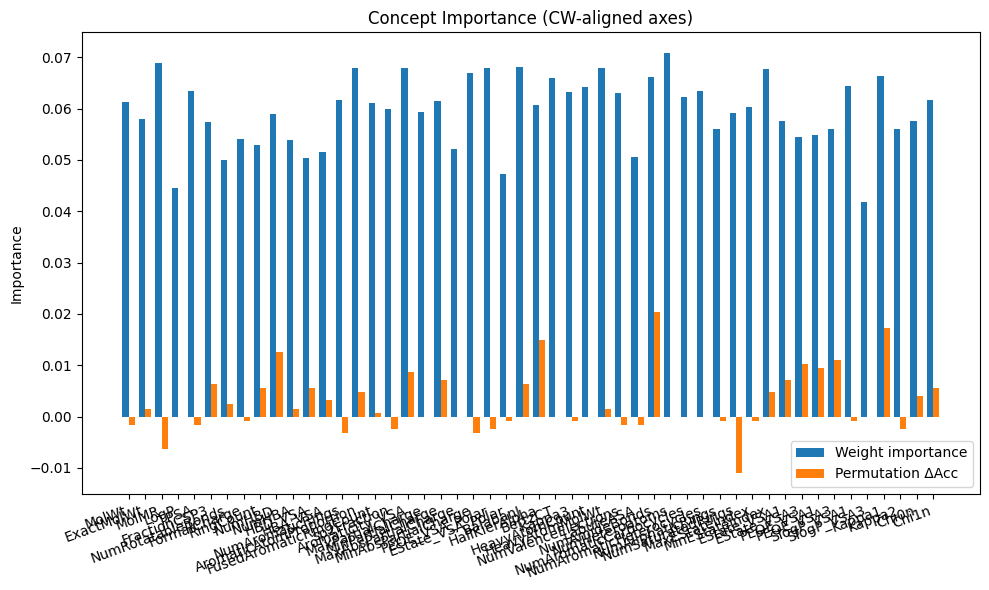


=== Weight-based importance ===
MolWt          : 0.0612
ExactMolWt     : 0.0579
MolMR          : 0.0689
LogP           : 0.0446
TPSA           : 0.0635
FractionCSP3   : 0.0574
NumRotatableBonds: 0.0500
FormalCharge   : 0.0540
RingCount      : 0.0530
NumHBD         : 0.0590
NumHBA         : 0.0538
HBD_VSA        : 0.0503
HBA_VSA        : 0.0514
NumAromaticRings: 0.0617
AromaticAtomProportion: 0.0678
FusedAromaticRingCount: 0.0611
sp2Fraction    : 0.0600
Aromaticity_VSA: 0.0680
MaxPartialCharge: 0.0593
MinPartialCharge: 0.0615
MaxAbsPartialCharge: 0.0520
MinAbsPartialCharge: 0.0670
PEOE_VSA_Polar : 0.0680
EState_VSA_Polar: 0.0472
BalabanJ       : 0.0681
HallKierAlpha  : 0.0607
BertzCT        : 0.0659
Kappa3         : 0.0633
HeavyAtomCount : 0.0643
HeavyAtomMolWt : 0.0679
NumValenceElectrons: 0.0631
LabuteASA      : 0.0506
NumAmideBonds  : 0.0662
NumHeteroatoms : 0.0708
NumAromaticCarbocycles: 0.0622
NumAromaticHeterocycles: 0.0635
NumAliphaticRings: 0.0560
NumSaturatedRings: 0.0592
MaxE

In [ ]:
# -*- coding: utf-8 -*-
# AttentiveFP + Concept Whitening (CW) — publication-ready minimal upgrades
# Deterministic build: env vars + seeds + DataLoader generator + split caching

# =========================
# [A] OS ENV — set BEFORE torch import  <<< DETERMINISM
# =========================
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"   # must be set before torch import
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

# Torch / PyG
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import AttentiveFP
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.data import Batch

# Metrics
import sklearn  # for version print
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, precision_score,
    recall_score, confusion_matrix, cohen_kappa_score,
    average_precision_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem import rdPartialCharges
from rdkit.Chem.EState import EStateIndices

# Linear algebra / Hungarian
from sklearn.linear_model import LinearRegression
from scipy.optimize import linear_sum_assignment

# Plot
import matplotlib.pyplot as plt

# =========================
# [B] Config
# =========================
CSV_PATH = "/content/AID1239_data_for_classification_04Nov2024.csv"  # <-- change if needed
SPLIT_TYPE = "scaffold"  # "scaffold" or "random"
RANDOM_SEED = 42

# Model / training params
HIDDEN_CHANNELS = 64
NUM_LAYERS = 4
NUM_TIMESTEPS = 4
DROPOUT = 0.2
LR_WARMUP = 3e-4
LR_FINETUNE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 64

EPOCHS_WARMUP = 50
EPOCHS_FINETUNE_MAX = 200
EARLY_STOP_PATIENCE = 20
ALIGN_EVAL_EVERY = 5

LAMBDA_CONCEPT = 0.0  # set to 0.01–0.05 to softly keep alignment during FT (optional)

# Optional caching paths  <<< CACHE/SPLIT
SPLIT_JSON = "split_indices.json"
CONCEPT_CACHE_NPZ = "concept_cache.npz"

# =========================
# [C] Determinism setup     <<< DETERMINISM
# =========================
def set_seed_all(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed_all()
torch.use_deterministic_algorithms(True)            # raise if non-deterministic op used
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_num_threads(1)


# =========================
# [D] Concept definitions (50)  <<< UPDATED
# =========================
CONCEPT_NAMES = [
    # --- Keep your original 28 (unchanged order) ---
    # A. Physicochemical Core (9)
    "MolWt", "ExactMolWt", "MolMR", "LogP", "TPSA",
    "FractionCSP3", "NumRotatableBonds", "FormalCharge", "RingCount",
    # B. H-bonding & Ionization (4)
    "NumHBD", "NumHBA", "HBD_VSA", "HBA_VSA",
    # C. Aromaticity & Conjugation (5)
    "NumAromaticRings", "AromaticAtomProportion", "FusedAromaticRingCount", "sp2Fraction", "Aromaticity_VSA",
    # D. Electrostatics & Charge (6)
    "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "PEOE_VSA_Polar", "EState_VSA_Polar",
    # E. Topology & 3D Shape (4)
    "BalabanJ", "HallKierAlpha", "BertzCT", "Kappa3",

    # --- Add 22 simple, RDKit-native single scalars ---
    # Physicochemical / counts
    "HeavyAtomCount", "HeavyAtomMolWt", "NumValenceElectrons", "LabuteASA",
    "NumAmideBonds", "NumHeteroatoms",

    # Ring family details
    "NumAromaticCarbocycles", "NumAromaticHeterocycles",
    "NumAliphaticRings", "NumSaturatedRings",

    # EState & VSA bins
    "MaxEStateIndex", "MinEStateIndex",
    "EState_VSA1", "EState_VSA3",
    "PEOE_VSA1", "PEOE_VSA3",
    "SlogP_VSA1", "SlogP_VSA3",

    # Topology
    "Kappa1", "Kappa2",
    "Chi0n", "Chi1n",
]
NUM_CONCEPTS = len(CONCEPT_NAMES)



# =========================
# [E] Featurization (close to AttentiveFP)
# =========================
ATOM_SYMBOLS = ["B","C","N","O","F","Si","P","S","Cl","As","Se","Br","Te","I","At","Metal"]
HYB_ORDER = ["SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"]

def one_hot(value, choices):
    vec = [0]*len(choices)
    idx = choices.index(value) if value in choices else None
    if idx is None: return vec
    vec[idx] = 1
    return vec

def atom_symbol_bucket(atom):
    sym = atom.GetSymbol()
    return sym if sym in ATOM_SYMBOLS[:-1] else "Metal"

def hybrid_bucket(atom):
    hyb = str(atom.GetHybridization()).upper()
    if "SP3D2" in hyb: return "SP3D2"
    if "SP3D"  in hyb: return "SP3D"
    if "SP3"   in hyb: return "SP3"
    if "SP2"   in hyb: return "SP2"
    if "SP"    in hyb: return "SP"
    return "OTHER"

def one_hot_degree(deg):
    d = deg if deg <= 5 else 5
    vec = [0]*6; vec[d] = 1; return vec

def one_hot_hcount(hc):
    h = hc if hc <= 4 else 4
    vec = [0]*5; vec[h] = 1; return vec

def bond_type_one_hot(bond):
    t = bond.GetBondType()
    vec = [0,0,0,0]
    mapping = {Chem.BondType.SINGLE:0, Chem.BondType.DOUBLE:1,
               Chem.BondType.TRIPLE:2, Chem.BondType.AROMATIC:3}
    vec[mapping.get(t,0)] = 1
    return vec

def bond_stereo_one_hot(bond):
    s = bond.GetStereo()
    opts = [Chem.BondStereo.STEREONONE, Chem.BondStereo.STEREOANY,
            Chem.BondStereo.STEREOZ, Chem.BondStereo.STEREOE]
    return one_hot(s, opts)

def mol_to_pyg(smiles: str, label: int) -> Data:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None

    x_list = []
    for atom in mol.GetAtoms():
        sym_vec = one_hot(atom_symbol_bucket(atom), ATOM_SYMBOLS)
        deg_vec = one_hot_degree(atom.GetDegree())
        charge = [atom.GetFormalCharge()]
        radical = [atom.GetNumRadicalElectrons()]
        hyb_vec = one_hot(hybrid_bucket(atom), HYB_ORDER)
        aromatic = [int(atom.GetIsAromatic())]
        hcount_vec = one_hot_hcount(atom.GetTotalNumHs())
        is_chiral_center = [int(atom.HasProp('_CIPCode'))]
        cip = atom.GetProp('_CIPCode') if atom.HasProp('_CIPCode') else ""
        chiral_type = one_hot(cip, ["R","S"])
        node_feat = sym_vec + deg_vec + charge + radical + hyb_vec + \
                    aromatic + hcount_vec + is_chiral_center + chiral_type
        x_list.append(node_feat)
    x = torch.tensor(np.asarray(x_list, dtype=np.float32), dtype=torch.float32)

    ei, ea = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        e = bond_type_one_hot(bond) + [float(bond.GetIsConjugated())] + \
            [float(bond.IsInRing())] + bond_stereo_one_hot(bond)  # 10 dims
        ei.extend([[i,j],[j,i]]); ea.extend([e, e])
    if not ei:
        for idx in range(mol.GetNumAtoms()):
            ei.append([idx, idx]); ea.append([1,0,0,0, 0,0, 1,0,0,0])

    edge_index = torch.tensor(np.asarray(ei).T, dtype=torch.long)
    edge_attr  = torch.tensor(np.asarray(ea, dtype=np.float32), dtype=torch.float32)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.y = torch.tensor([label], dtype=torch.long)
    data.smiles = smiles
    return data

# =========================
# [F] Concepts (50 descriptors)  <<< UPDATED
# =========================
def compute_concepts(smiles_list: List[str]) -> np.ndarray:
    """
    Returns an (N, 50) float32 array in the order of CONCEPT_NAMES.
    Only simple RDKit scalar descriptors; no lists.
    """
    # Feature factory for HBD/HBA VSA (uses BaseFeatures.fdef)
    fdef = os.path.join(RDConfig.RDDataDir, "BaseFeatures.fdef")
    feat_factory = ChemicalFeatures.BuildFeatureFactory(fdef)

    rows = []
    for smi in smiles_list:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            rows.append([np.nan]*NUM_CONCEPTS)
            continue

        # Charges for PEOE-based fields
        try:
            rdPartialCharges.ComputeGasteigerCharges(m)
        except Exception:
            pass

        # Per-atom EState
        try:
            est_idx = EStateIndices(m)
        except Exception:
            est_idx = [0.0]*m.GetNumAtoms()

        # Labute atom areas (no hydrogens)
        try:
            atom_areas = rdMolDescriptors._CalcLabuteAtomContribs(m)[0]
        except Exception:
            atom_areas = [0.0]*m.GetNumAtoms()

        # Helper: VSA sum over a set of atom indices
        def vsa_sum(ids):
            if not ids: return 0.0
            return float(sum(atom_areas[i] for i in ids if 0 <= i < len(atom_areas)))

        # Donor/Acceptor atom indices via features
        feats = feat_factory.GetFeaturesForMol(m)
        donor_ids    = sorted({aid for f in feats if f.GetType()=="Donor"    for aid in f.GetAtomIds()})
        acceptor_ids = sorted({aid for f in feats if f.GetType()=="Acceptor" for aid in f.GetAtomIds()})

        # Aromatic atoms
        aromatic_ids = [a.GetIdx() for a in m.GetAtoms() if a.GetIsAromatic()]

        # Fractions over heavy atoms only
        heavy_atoms = [a for a in m.GetAtoms() if a.GetAtomicNum() > 1]
        heavy_n = max(1, len(heavy_atoms))
        sp2_fraction = sum(int(a.GetHybridization()==Chem.rdchem.HybridizationType.SP2) for a in heavy_atoms) / heavy_n
        aromatic_atom_prop = sum(int(a.GetIsAromatic()) for a in heavy_atoms) / heavy_n

        # Fused aromatic ring count (simple: count pairs sharing ≥2 atoms)
        fused_count = 0
        ri = m.GetRingInfo()
        aro_rings = [tuple(r) for r in ri.AtomRings() if all(m.GetAtomWithIdx(i).GetIsAromatic() for i in r)]
        L = len(aro_rings)
        if L > 1:
            for i in range(L):
                si = set(aro_rings[i])
                for j in range(i+1, L):
                    if len(si.intersection(aro_rings[j])) >= 2:
                        fused_count += 1

        # Formal charge
        formal_charge = float(sum(a.GetFormalCharge() for a in m.GetAtoms()))

        # PEOE_VSA_Polar (simple threshold on |Gasteiger|, sum atom areas)
        g_charges = []
        for a in m.GetAtoms():
            try:
                q = float(a.GetProp("_GasteigerCharge"))
                if not np.isfinite(q): q = 0.0
            except Exception:
                q = 0.0
            g_charges.append(q)
        PEOE_POLAR_THR = 0.2
        peoe_polar_ids = [i for i, q in enumerate(g_charges) if abs(q) >= PEOE_POLAR_THR]

        # EState_VSA_Polar = sum(area * |EState|)
        estate_vsa_polar = 0.0
        for i in range(min(len(atom_areas), len(est_idx))):
            estate_vsa_polar += atom_areas[i] * abs(float(est_idx[i]))

        # Build the 50-element feature row (order = CONCEPT_NAMES)
        row = [
            # --- original 28 ---
            # A. Physicochemical Core (9)
            Descriptors.MolWt(m),
            Descriptors.ExactMolWt(m),
            Descriptors.MolMR(m),
            Descriptors.MolLogP(m),
            rdMolDescriptors.CalcTPSA(m),
            rdMolDescriptors.CalcFractionCSP3(m),
            rdMolDescriptors.CalcNumRotatableBonds(m),
            formal_charge,
            rdMolDescriptors.CalcNumRings(m),

            # B. H-bonding & Ionization (4)
            rdMolDescriptors.CalcNumHBD(m),
            rdMolDescriptors.CalcNumHBA(m),
            vsa_sum(donor_ids),     # HBD_VSA
            vsa_sum(acceptor_ids),  # HBA_VSA

            # C. Aromaticity & Conjugation (5)
            rdMolDescriptors.CalcNumAromaticRings(m),
            aromatic_atom_prop,
            float(fused_count),
            sp2_fraction,
            vsa_sum(aromatic_ids),  # Aromaticity_VSA

            # D. Electrostatics & Charge (6)
            Descriptors.MaxPartialCharge(m),
            Descriptors.MinPartialCharge(m),
            Descriptors.MaxAbsPartialCharge(m),
            Descriptors.MinAbsPartialCharge(m),
            vsa_sum(peoe_polar_ids),   # PEOE_VSA_Polar
            float(estate_vsa_polar),   # EState_VSA_Polar

            # E. Topology & 3D Shape (4)
            Descriptors.BalabanJ(m),
            Descriptors.HallKierAlpha(m),
            Descriptors.BertzCT(m),
            Descriptors.Kappa3(m),

            # --- added 22 simple RDKit scalars ---
            # Physicochemical / counts
            Descriptors.HeavyAtomCount(m),
            Descriptors.HeavyAtomMolWt(m),
            Descriptors.NumValenceElectrons(m),   # safe in Descriptors.*
            Descriptors.LabuteASA(m),
            rdMolDescriptors.CalcNumAmideBonds(m),
            Descriptors.NumHeteroatoms(m),

            # Ring family details
            rdMolDescriptors.CalcNumAromaticCarbocycles(m),
            rdMolDescriptors.CalcNumAromaticHeterocycles(m),
            rdMolDescriptors.CalcNumAliphaticRings(m),
            rdMolDescriptors.CalcNumSaturatedRings(m),

            # EState & VSA bins
            Descriptors.MaxEStateIndex(m),
            Descriptors.MinEStateIndex(m),
            Descriptors.EState_VSA1(m),
            Descriptors.EState_VSA3(m),
            Descriptors.PEOE_VSA1(m),
            Descriptors.PEOE_VSA3(m),
            Descriptors.SlogP_VSA1(m),
            Descriptors.SlogP_VSA3(m),

            # Topology
            Descriptors.Kappa1(m),
            Descriptors.Kappa2(m),
            Descriptors.Chi0n(m),
            Descriptors.Chi1n(m),
        ]

        rows.append([float(x) for x in row])

    return np.asarray(rows, dtype=np.float32)

# ---------------------- END CONCEPT EXTRACTION ----------------------



# =========================
# [G] Dataset loading + splitting (+ optional cached splits)  <<< CACHE/SPLIT
# =========================
def load_csv_make_dataset(csv_path: str) -> Tuple[List[Data], List[str]]:
    df = pd.read_csv(csv_path)
    mapping = {'Active':1,'Inactive':0,'active':1,'inactive':0,'ACTIVE':1,'INACTIVE':0}
    df = df[df['PUBCHEM_ACTIVITY_OUTCOME'].isin(mapping)]
    smiles = df['SMILES'].tolist()
    labels = [mapping[v] for v in df['PUBCHEM_ACTIVITY_OUTCOME']]
    data_list, smiles_clean = [], []
    for smi, y in zip(smiles, labels):
        g = mol_to_pyg(smi, y)
        if g is not None:
            data_list.append(g)
            smiles_clean.append(smi)
    return data_list, smiles_clean

def class_counts(data_list: List[Data]) -> Dict[int, int]:
    ys = [int(d.y.item()) for d in data_list]
    return {0: ys.count(0), 1: ys.count(1)}

def generate_scaffolds(smiles_list: List[str]) -> Dict[str, List[int]]:
    scaff2idx = {}
    for i, smi in enumerate(smiles_list):
        m = Chem.MolFromSmiles(smi)
        scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=m) if m else ""
        scaff2idx.setdefault(scaf, []).append(i)
    return scaff2idx

def scaffold_split_balanced(data: List[Data], smiles: List[str], frac=(0.8, 0.1, 0.1), seed=RANDOM_SEED):
    assert abs(sum(frac) - 1.0) < 1e-6
    rng = np.random.RandomState(seed)
    scaff2idx = generate_scaffolds(smiles)
    buckets = sorted(scaff2idx.values(), key=lambda v: len(v), reverse=True)
    n = len(data); n_train, n_val = int(frac[0]*n), int(frac[1]*n)

    def pick(idxs): return [data[i] for i in idxs], [smiles[i] for i in idxs]
    train_idx, val_idx, test_idx = [], [], []
    train_counts = {0:0, 1:0}; val_counts = {0:0, 1:0}; test_counts = {0:0, 1:0}

    def add_group(target, counts, idxs):
        target.extend(idxs)
        for i in idxs: counts[int(data[i].y.item())] += 1

    for grp in buckets:
        zeros = sum(int(data[i].y.item()) == 0 for i in grp); ones = len(grp) - zeros
        options = []
        for name, idx_list, cnts, cap in [
            ("train", train_idx, train_counts, n_train),
            ("val",   val_idx,   val_counts,   n_val),
            ("test",  test_idx,  test_counts,  n)
        ]:
            if len(idx_list) + len(grp) <= cap:
                z_after = cnts[0] + zeros; o_after = cnts[1] + ones
                options.append((abs(z_after - o_after), name))
        if not options: options = [(0, "test")]
        _, choice = sorted(options)[0]
        if choice == "train": add_group(train_idx, train_counts, grp)
        elif choice == "val": add_group(val_idx, val_counts, grp)
        else: add_group(test_idx, test_counts, grp)

    def has_both(idxs):
        labs = [int(data[i].y.item()) for i in idxs]
        return (0 in labs) and (1 in labs)

    if not (has_both(train_idx) and has_both(val_idx) and has_both(test_idx)):
        labels = [int(d.y.item()) for d in data]
        all_idx = np.arange(len(data))
        tr, te = train_test_split(all_idx, test_size=0.2, stratify=labels, random_state=seed)
        tr_labels = [labels[i] for i in tr]
        tr, va = train_test_split(tr, test_size=0.2, stratify=tr_labels, random_state=seed)
        return pick(tr), pick(va), pick(te)

    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return pick(train_idx), pick(val_idx), pick(test_idx)

def random_split(data: List[Data], smiles: List[str], seed=RANDOM_SEED):
    labels = [int(d.y.item()) for d in data]
    idx_all = np.arange(len(data))
    idx_train, idx_test = train_test_split(idx_all, test_size=0.2, stratify=labels, random_state=seed)
    labels_train = [labels[i] for i in idx_train]
    idx_tr, idx_val = train_test_split(idx_train, test_size=0.2, stratify=labels_train, random_state=seed)
    def pick(idxs): return [data[i] for i in idxs], [smiles[i] for i in idxs]
    return pick(idx_tr), pick(idx_val), pick(idx_test)

# =========================
# [H] Concept Whitening
# =========================
class ConceptWhitening:
    def __init__(self, input_dim, num_concepts, device):
        self.input_dim = input_dim
        self.num_concepts = num_concepts
        self.device = device
        self.mu_t = None
        self.Sigma_inv_root_t = None
        self.R_t = None
        self.concept_scaler = StandardScaler()

    def fit(self, Z: np.ndarray, Yc: np.ndarray):
        print(f"\n[CW] Fitting on {Z.shape[0]} samples, dim={Z.shape[1]}...")
        Yc_scaled = self.concept_scaler.fit_transform(Yc)

        mu = Z.mean(axis=0)
        Zc = Z - mu
        Sigma = np.cov(Zc, rowvar=False) + 1e-4*np.eye(Zc.shape[1])
        vals, vecs = np.linalg.eigh(Sigma)
        vals = np.clip(vals, 1e-6, None)
        Sigma_inv_root = vecs @ np.diag(1.0/np.sqrt(vals)) @ vecs.T
        Zw = Zc @ Sigma_inv_root

        W = np.zeros((Zw.shape[1], self.num_concepts))
        for i in range(self.num_concepts):
            lr = LinearRegression().fit(Zw, Yc_scaled[:, i])
            W[:, i] = lr.coef_

        Qc, _ = np.linalg.qr(W)  # (d x k)
        filler = Zw.shape[1] - self.num_concepts
        if filler > 0:
            np.random.seed(RANDOM_SEED)
            ext = np.random.randn(Zw.shape[1], filler)
            Q_full, _ = np.linalg.qr(np.concatenate([Qc, ext], axis=1))
            R = Q_full
        else:
            R = Qc

        self.mu_t = torch.from_numpy(mu).float().to(self.device)
        self.Sigma_inv_root_t = torch.from_numpy(Sigma_inv_root).float().to(self.device)
        self.R_t = torch.from_numpy(R).float().to(self.device)
        print("[CW] Base whitening+rotation fitted.")

    def transform(self, Z_t):
        """Accepts torch.Tensor or np.ndarray; returns same type."""
        is_numpy = isinstance(Z_t, np.ndarray)
        Z = torch.from_numpy(Z_t).float().to(self.mu_t.device) if is_numpy else Z_t.to(self.mu_t.device).float()
        out = (Z - self.mu_t) @ self.Sigma_inv_root_t @ self.R_t
        return out.detach().cpu().numpy() if is_numpy else out

    def align_axes_by_corr(self, Z_train, Yc_train, concept_names):
        """
        Align first K whitened axes to concepts by maximizing |corr|.
        """
        K = self.num_concepts
        assert K <= self.input_dim, "num_concepts must be <= input_dim"

        Zt = torch.from_numpy(Z_train).float().to(self.device) if isinstance(Z_train, np.ndarray) else Z_train.to(self.device).float()
        with torch.no_grad():
            Zc = self.transform(Zt)[:, :K].detach().cpu().numpy()

        Ys = self.concept_scaler.transform(np.asarray(Yc_train, dtype=np.float64))

        def _colwise_fix(a):
            a = np.asarray(a, dtype=np.float64)
            mask = np.isfinite(a)
            if mask.all(): return a
            med = np.nanmedian(np.where(mask, a, np.nan), axis=0)
            med = np.where(np.isfinite(med), med, 0.0)
            return np.where(mask, a, med)

        Zc = _colwise_fix(Zc); Ys = _colwise_fix(Ys)

        def _zscore_cols(a, eps=1e-12):
            a = a - np.mean(a, axis=0, keepdims=True)
            std = np.std(a, axis=0, ddof=1, keepdims=True)
            std = np.where(std < eps, eps, std)
            return a / std

        Zc_z = _zscore_cols(Zc); Ys_z = _zscore_cols(Ys)
        C = Zc_z.T @ Ys_z
        C = np.where(np.isfinite(C), C, 0.0)

        row, col = linear_sum_assignment(-np.abs(C))

        P = np.zeros((self.input_dim, self.input_dim), dtype=np.float64)
        if self.input_dim > K:
            np.fill_diagonal(P[K:, K:], 1.0)
        signs = np.sign(C[row, col]); signs[signs == 0] = 1.0
        for i, j, s in zip(row, col, signs): P[i, j] = s

        P_t = torch.from_numpy(P).float().to(self.device)
        with torch.no_grad():
            self.R_t = self.R_t @ P_t

        self.axis_match_ = [(int(r), int(c), float(C[r, c])) for r, c in zip(row, col)]
        self.concept_names_ = list(concept_names)
        print("[CW] Axis assignment by |corr| completed.")
        for r, c, v in self.axis_match_:
            cname = concept_names[c] if c < len(concept_names) else f"c{c}"
            print(f"   axis {r:02d} → {cname:20s} corr={v:+.3f}")
        return row, col, C

# =========================
# [I] Model
# =========================
class AttentiveFPWithCW(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_channels, num_layers, num_timesteps, dropout):
        super().__init__()
        self.gnn = AttentiveFP(
            in_channels=node_feat_dim,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            edge_dim=edge_feat_dim,
            num_layers=num_layers,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels//2, 2)
        )

    def forward(self, batch: Batch, cw: ConceptWhitening=None):
        z = self.gnn(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        if cw is not None:
            z = cw.transform(z)
        return self.classifier(z)

    def representations(self, loader, device) -> np.ndarray:
        self.eval()
        reps = []
        with torch.no_grad():
            for b in loader:
                b = b.to(device)
                reps.append(self.gnn(b.x, b.edge_index, b.edge_attr, b.batch).cpu())
        return torch.cat(reps, dim=0).numpy()

# =========================
# [J] Training / Evaluation
# =========================
def train_epoch(model, loader, optimizer, device, cw=None, lambda_concept=0.0):
    model.train()
    total_loss, preds_all, labels_all = 0.0, [], []
    for batch in loader:
        batch = batch.to(device)
        y = batch.y.view(-1).long()
        optimizer.zero_grad()
        logits = model(batch, cw=cw)
        loss = F.cross_entropy(logits, y)
        if cw is not None and lambda_concept > 0.0:
            pass
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())
        preds_all.extend(torch.argmax(logits, 1).cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    return total_loss/len(loader), acc

def evaluate(model, loader, device, cw=None, verbose=True):
    model.eval()
    preds_all, labels_all, probs_all = [], [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            y = batch.y.view(-1).long()
            logits = model(batch, cw=cw)
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
            probs_all.extend(probs.cpu().numpy().tolist())
    try: auc = roc_auc_score(labels_all, probs_all)
    except ValueError: auc = float("nan")
    cm = confusion_matrix(labels_all, preds_all)
    if verbose: print("Confusion Matrix:\n", cm)
    return dict(
        accuracy=accuracy_score(labels_all, preds_all),
        roc_auc=auc,
        f1=f1_score(labels_all, preds_all),
        precision=precision_score(labels_all, preds_all, zero_division=0),
        recall=recall_score(labels_all, preds_all),
        kappa=cohen_kappa_score(labels_all, preds_all),
        confusion_matrix=cm
    )

def collect_probs_and_labels(model, loader, device, cw=None):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(torch.softmax(model(b, cw=cw), 1)[:,1].cpu().numpy().tolist())
    return np.array(ys), np.array(ps)

def pr_auc(model, loader, device, cw=None):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    return float(average_precision_score(y, p))

def brier(model, loader, device, cw=None):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    return float(brier_score_loss(y, p))

def reliability_bins(model, loader, device, cw=None, n_bins=10):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=n_bins, strategy='uniform')
    return mean_pred, frac_pos

def alignment_corr(model, loader, device, cw: ConceptWhitening, smiles_list: List[str]) -> Dict[str, float]:
    Z = model.representations(loader, device)
    # Cached concept use handled by caller; keep API identical
    Y = compute_concepts(smiles_list)
    Ys = cw.concept_scaler.transform(Y)
    with torch.no_grad():
        Zc = cw.transform(torch.from_numpy(Z).float().to(device)).cpu().numpy()
    k = cw.num_concepts
    C = np.corrcoef(Zc[:, :k].T, Ys.T)[:k, k:]
    res = {CONCEPT_NAMES[i]: float(np.nan_to_num(C[i, i])) for i in range(k)}
    return res

def bootstrap_ci_metric(y, p, fn, n=1000, alpha=0.05, rng=42):
    r = np.random.RandomState(rng)
    vals = []
    idx = np.arange(len(y))
    for _ in range(n):
        s = r.choice(idx, size=len(idx), replace=True)
        vals.append(fn(y[s], p[s]))
    vals = np.sort(vals)
    lo = np.percentile(vals, 100*alpha/2)
    hi = np.percentile(vals, 100*(1-alpha/2))
    return float(np.mean(vals)), float(lo), float(hi)

def roc_auc_ci(model, loader, device, cw=None, n=1000):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    mean_, lo, hi = bootstrap_ci_metric(y, p, roc_auc_score, n=n)
    return mean_, lo, hi

def pr_auc_ci(model, loader, device, cw=None, n=1000):
    y, p = collect_probs_and_labels(model, loader, device, cw)
    mean_, lo, hi = bootstrap_ci_metric(y, p, average_precision_score, n=n)
    return mean_, lo, hi

# Concept importance (weights + permutation)
def concept_importance(model, test_loader, device, cw):
    names = CONCEPT_NAMES
    W = model.classifier[0].weight.detach().cpu().numpy()
    weights = np.mean(np.abs(W[:, :len(names)]), axis=0)

    model.eval()
    reps, labels = [], []
    with torch.no_grad():
        for b in test_loader:
            b = b.to(device)
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z).cpu()
            reps.append(zc); labels.append(b.y.cpu())
    reps = torch.cat(reps, 0); labels = torch.cat(labels, 0).view(-1).long()
    n = reps.size(0)

    with torch.no_grad():
        base_preds = torch.argmax(model.classifier(reps.to(device)), 1).cpu().numpy()
    base_acc = accuracy_score(labels.numpy(), base_preds)

    drops = {}
    for d, cname in enumerate(names):
        rp = reps.clone()
        rp[:, d] = rp[torch.randperm(n), d]  # uses global seed from set_seed_all()
        with torch.no_grad():
            pr = torch.argmax(model.classifier(rp.to(device)), 1).cpu().numpy()
        drops[cname] = base_acc - accuracy_score(labels.numpy(), pr)

    x = np.arange(len(names)); w = 0.38
    plt.figure(figsize=(10,6))
    plt.bar(x - w/2, weights, width=w, label="Weight importance")
    plt.bar(x + w/2, [drops[n] for n in names], width=w, label="Permutation ΔAcc")
    plt.xticks(x, names, rotation=20, ha='right'); plt.ylabel("Importance")
    plt.title("Concept Importance (CW-aligned axes)")
    plt.legend(); plt.tight_layout(); plt.show()

    print("\n=== Weight-based importance ===")
    for c, s in zip(names, weights): print(f"{c:15s}: {s:.4f}")


    # ---- Save weight importance to CSV ----
    df_weight = pd.DataFrame({
        "Concept": names,
        "WeightImportance": weights
    })
    df_weight.to_csv("cw_weight_importance.csv", index=False)
    print("Saved → cw_weight_importance.csv")

    print("\n=== Permutation ΔAccuracy ===")
    for c in names: print(f"{c:15s}: {drops[c]:.4f}")

    # ---- Save permutation importance to CSV ----
    df_perm = pd.DataFrame({
        "Concept": names,
        "Permutation_DeltaAcc": [drops[c] for c in names]
    })
    df_perm.to_csv("cw_permutation_importance.csv", index=False)
    print("Saved → cw_permutation_importance.csv")


# Sign harmonization (post-hoc)
def harmonize_concept_signs(model, cw, loader, device, smiles, concept_names):
    Z = model.representations(loader, device)
    Y = compute_concepts(smiles)
    Ys = cw.concept_scaler.transform(Y)
    with torch.no_grad():
        Zc = cw.transform(torch.from_numpy(Z).float().to(device)).cpu().numpy()
    k = cw.num_concepts
    C = np.corrcoef(Zc[:, :k].T, Ys.T)[:k, k:].diagonal()

    flips = (C < 0).astype(np.int32)
    if flips.any():
        with torch.no_grad():
            S = torch.eye(cw.input_dim, device=cw.R_t.device)
            for i in range(k):
                if flips[i]: S[i,i] = -1.0
            cw.R_t = cw.R_t @ S
            W = model.classifier[0].weight
            W[:, :k] *= torch.tensor([ -1.0 if f else 1.0 for f in flips ],
                                     device=W.device).view(1, k)
    with torch.no_grad():
        Zc2 = cw.transform(torch.from_numpy(Z).float().to(device)).cpu().numpy()
    C2 = np.corrcoef(Zc2[:, :k].T, Ys.T)[:k, k:].diagonal()
    print("\n[Sign harmonization]")
    for name, c_before, c_after in zip(concept_names, C, C2):
        print(f"  {name:15s}: {c_before:+.3f} → {c_after:+.3f}")

# Threshold helpers
def best_f1_threshold(model, loader, device, cw=None):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            y = b.y.view(-1).long()
            p = torch.softmax(model(b, cw=cw), 1)[:,1]
            ys.extend(y.cpu().numpy().tolist())
            ps.extend(p.cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    ts = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(ys, (ps>=t).astype(int)) for t in ts]
    t_star = ts[int(np.argmax(f1s))]
    return float(t_star)

def evaluate_at_threshold(model, loader, device, cw, thr):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(torch.softmax(model(b, cw=cw),1)[:,1].cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    preds = (ps >= thr).astype(int)
    return dict(
        accuracy=accuracy_score(ys, preds),
        roc_auc=roc_auc_score(ys, ps),
        f1=f1_score(ys, preds),
        precision=precision_score(ys, preds, zero_division=0),
        recall=recall_score(ys, preds),
        kappa=cohen_kappa_score(ys, preds),
        confusion_matrix=confusion_matrix(ys, preds),
        threshold=thr
    )

# Concept-only / without-concepts controls
def eval_concept_only(model, loader, device, cw, k):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z); zc[:, k:] = 0.0
            p = torch.softmax(model.classifier(zc), 1)[:,1]
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(p.cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    return dict(roc_auc=roc_auc_score(ys, ps))

def eval_without_concepts(model, loader, device, cw, k):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z); zc[:, :k] = 0.0
            p = torch.softmax(model.classifier(zc), 1)[:,1]
            ys.extend(b.y.view(-1).cpu().numpy().tolist())
            ps.extend(p.cpu().numpy().tolist())
    ys = np.array(ys); ps = np.array(ps)
    return dict(roc_auc=roc_auc_score(ys, ps))

def export_predictions_csv(model, loader, smiles, device, cw, path="predictions.csv", thr=0.5):
    model.eval()
    rows = []; i0 = 0
    with torch.no_grad():
        for b in loader:
            n = b.y.view(-1).shape[0]
            idx = np.arange(i0, i0+n)
            b = b.to(device)
            probs = torch.softmax(model(b, cw=cw), 1)[:,1].cpu().numpy()
            preds = (probs >= thr).astype(int)
            labels = b.y.view(-1).cpu().numpy()
            z = model.gnn(b.x, b.edge_index, b.edge_attr, b.batch)
            zc = cw.transform(z)[:, :NUM_CONCEPTS].cpu().numpy()
            for j in range(n):
                rows.append({
                    "smiles": smiles[idx[j]],
                    "label": int(labels[j]),
                    "prob": float(probs[j]),
                    "pred": int(preds[j]),
                    **{f"concept_{CONCEPT_NAMES[k]}": float(zc[j,k]) for k in range(NUM_CONCEPTS)}
                })
            i0 += n
    pd.DataFrame(rows).to_csv(path, index=False)
    print(f"Saved per-molecule predictions → {path}")

# =========================
# [K] Main
# =========================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        from torch_geometric import __version__ as pyg_version
    except Exception:
        pyg_version = "unknown"
    import rdkit
    print("Versions:",
          "torch", torch.__version__,
          "| pyg", pyg_version,
          "| sklearn", sklearn.__version__,
          "| rdkit", rdkit.__version__,
          "| numpy", np.__version__)
    print("Device:", device)

    data_all, smiles_all = load_csv_make_dataset(CSV_PATH)
    print(f"Loaded {len(data_all)} molecules.")

    # ----- splits (cached if available)  <<< CACHE/SPLIT
    use_cached_split = os.path.exists(SPLIT_JSON)
    if use_cached_split:
        import json
        idx = json.load(open(SPLIT_JSON, "r"))
        def pick(idxs): return [data_all[i] for i in idxs], [smiles_all[i] for i in idxs]
        (train_data, train_smiles) = pick(idx["train"])
        (val_data,   val_smiles)   = pick(idx["val"])
        (test_data,  test_smiles)  = pick(idx["test"])
        print(f"Loaded cached split → {SPLIT_JSON}")
    else:
        if SPLIT_TYPE.lower() == "scaffold":
            (train_data, train_smiles), (val_data, val_smiles), (test_data, test_smiles) = \
                scaffold_split_balanced(data_all, smiles_all, frac=(0.8, 0.1, 0.1), seed=RANDOM_SEED)
        else:
            (train_data, train_smiles), (val_data, val_smiles), (test_data, test_smiles) = \
                random_split(data_all, smiles_all, seed=RANDOM_SEED)
        # save split for future exact reproducibility
        import json
        splits = {
            "train": [smiles_all.index(s) for s in train_smiles],
            "val":   [smiles_all.index(s) for s in val_smiles],
            "test":  [smiles_all.index(s) for s in test_smiles],
        }
        json.dump(splits, open(SPLIT_JSON, "w"))
        print(f"Saved split indices → {SPLIT_JSON}")

    print(f"Split sizes — Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    print("Class balance:",
          "Train", class_counts(train_data),
          "Val", class_counts(val_data),
          "Test", class_counts(test_data))

    node_dim = train_data[0].x.shape[1]
    edge_dim = train_data[0].edge_attr.shape[1]

    # DataLoader: fixed generator for shuffle reproducibility  <<< DETERMINISM
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)
    train_loader = GeoDataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, generator=g)
    val_loader   = GeoDataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = GeoDataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = AttentiveFPWithCW(
        node_feat_dim=node_dim,
        edge_feat_dim=edge_dim,
        hidden_channels=HIDDEN_CHANNELS,
        num_layers=NUM_LAYERS,
        num_timesteps=NUM_TIMESTEPS,
        dropout=DROPOUT
    ).to(device)

    # 1) Warm-up
    opt = torch.optim.Adam(model.parameters(), lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)
    print("\n[Warm-up training]")
    for ep in range(1, EPOCHS_WARMUP+1):
        loss, acc = train_epoch(model, train_loader, opt, device, cw=None, lambda_concept=0.0)
        if ep % 5 == 0 or ep == 1 or ep == EPOCHS_WARMUP:
            val_metrics = evaluate(model, val_loader, device, cw=None, verbose=False)
            val_auc = val_metrics['roc_auc']
            if np.isnan(val_auc): val_auc = 0.5
            print(f"Epoch {ep:03d} | TrainAcc={acc:.3f} | ValAUC={val_auc:.3f}")

    # 2) Freeze, fit CW on TRAIN reps (+ cached concepts)  <<< CACHE/SPLIT
    for p in model.parameters(): p.requires_grad = False
    Z_train = model.representations(GeoDataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0), device)

    if os.path.exists(CONCEPT_CACHE_NPZ):
        cache = np.load(CONCEPT_CACHE_NPZ, allow_pickle=False)
        Yc_train = cache["Yc_train"]; Yc_val = cache["Yc_val"]; Yc_test = cache["Yc_test"]
        print(f"Loaded concept cache → {CONCEPT_CACHE_NPZ}")
    else:
        Yc_train = compute_concepts(train_smiles)
        Yc_val   = compute_concepts(val_smiles)
        Yc_test  = compute_concepts(test_smiles)
        np.savez(CONCEPT_CACHE_NPZ, Yc_train=Yc_train, Yc_val=Yc_val, Yc_test=Yc_test)
        print(f"Saved concept cache → {CONCEPT_CACHE_NPZ}")

    cw = ConceptWhitening(input_dim=HIDDEN_CHANNELS, num_concepts=NUM_CONCEPTS, device=device)
    cw.fit(Z_train, Yc_train)
    print("\n[CW] Aligning axes by correlation...")
    row, col, C = cw.align_axes_by_corr(Z_train, Yc_train, CONCEPT_NAMES)
    #cw.align_axes_by_corr(Z_train, Yc_train, CONCEPT_NAMES)

    # 3) Unfreeze and fine-tune with CW in-place
    for p in model.parameters(): p.requires_grad = True
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=LR_FINETUNE, weight_decay=WEIGHT_DECAY)

    print("\n[Fine-tuning with CW] (early stopping on Val ROC-AUC)")
    best_auc, best_state = -1.0, None
    best_cw_R = cw.R_t.detach().clone()
    patience = EARLY_STOP_PATIENCE
    for ep in range(1, EPOCHS_FINETUNE_MAX+1):
        loss, acc = train_epoch(model, train_loader, opt, device, cw=cw, lambda_concept=LAMBDA_CONCEPT)
        val_metrics = evaluate(model, val_loader, device, cw=cw, verbose=False)
        val_auc = val_metrics['roc_auc']; val_auc_cmp = 0.5 if np.isnan(val_auc) else val_auc

        if ep % ALIGN_EVAL_EVERY == 0:
            corr = alignment_corr(model, val_loader, device, cw, val_smiles)
            corr_str = " | ".join([f"{k}:{v:.2f}" for k,v in corr.items()])
        else:
            corr_str = ""

        print(f"FT {ep:03d} | TrainAcc={acc:.3f} | ValAUC={(0.5 if np.isnan(val_auc) else val_auc):.3f} | "
              f"ValF1={val_metrics['f1']:.3f}  {corr_str}")

        if val_auc_cmp > best_auc:
            best_auc = val_auc_cmp
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_cw_R = cw.R_t.detach().cpu().clone()
            patience = EARLY_STOP_PATIENCE
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {ep}. Best ValAUC={best_auc:.3f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        cw.R_t = best_cw_R.to(device)

    # Thresholded test
    thr = best_f1_threshold(model, val_loader, device, cw=cw)
    print(f"\nChosen threshold from VAL (max F1): {thr:.2f}")
    test_thr_metrics = evaluate_at_threshold(model, test_loader, device, cw, thr)
    print("\n[Test @ F1-opt threshold]")
    print({k: (round(v,4) if isinstance(v, (float,int)) else v) for k,v in test_thr_metrics.items() if k!='confusion_matrix'})
    print("Confusion Matrix:\n", test_thr_metrics['confusion_matrix'])

    # Sign harmonization
    harmonize_concept_signs(model, cw, test_loader, device, test_smiles, CONCEPT_NAMES)

    # Final test (threshold-free)
    print("\n[Final Test Evaluation]")
    test_metrics = evaluate(model, test_loader, device, cw=cw, verbose=True)
    print({k: (round(v,4) if isinstance(v, (float, int)) else v) for k,v in test_metrics.items() if k!='confusion_matrix'})

    # Alignment report (TEST)
    final_corr = alignment_corr(model, test_loader, device, cw, test_smiles)
    print("\nPer-concept correlation on TEST (CW-aligned axes):")
    for k, v in final_corr.items(): print(f"  {k:15s}: {v:.3f}")

    df_corr = pd.DataFrame({
      "Concept": list(final_corr.keys()),
      "Correlation": list(final_corr.values())
    })
    df_corr.to_csv("cw_alignment_test.csv", index=False)
    print("Saved → cw_alignment_test.csv")

    # Concept importance
    concept_importance(model, test_loader, device, cw)

    # Ablations & CIs
    print("\n[Concept ablations]")
    print("Test ROC-AUC (concept-only):", eval_concept_only(model, test_loader, device, cw, NUM_CONCEPTS))
    print("Test ROC-AUC (without concepts):", eval_without_concepts(model, test_loader, device, cw, NUM_CONCEPTS))
    print("\nAdditional test metrics:")
    print("  PR-AUC:", round(pr_auc(model, test_loader, device, cw), 4))
    print("  Brier :", round(brier(model, test_loader, device, cw), 4))
    mean_auc, lo_auc, hi_auc = roc_auc_ci(model, test_loader, device, cw, n=1000)
    mean_ap,  lo_ap,  hi_ap  = pr_auc_ci(model, test_loader, device, cw, n=1000)
    print(f"\nTest ROC-AUC 95% CI: {mean_auc:.4f} [{lo_auc:.4f}, {hi_auc:.4f}]")
    print(f"Test PR-AUC  95% CI: {mean_ap:.4f}  [{lo_ap:.4f},  {hi_ap:.4f}]")

    # Save artifacts
    torch.save({
        "model_state": model.state_dict(),
        "cw_mu": cw.mu_t.cpu(),
        "cw_sigma_inv_root": cw.Sigma_inv_root_t.cpu(),
        "cw_R": cw.R_t.cpu(),
        "concept_scaler_mean": cw.concept_scaler.mean_,
        "concept_scaler_scale": cw.concept_scaler.scale_,
        "config": {
            "node_dim": node_dim, "edge_dim": edge_dim,
            "hidden": HIDDEN_CHANNELS, "layers": NUM_LAYERS, "timesteps": NUM_TIMESTEPS,
            "dropout": DROPOUT, "split": SPLIT_TYPE
        }
    }, "attentivefp_cw_checkpoint.pt")
    print("\nSaved checkpoint → attentivefp_cw_checkpoint.pt")

    print(cw.axis_match_) # The axis_match_ list
    # Save correlation matrix for interpretation
    np.savetxt("cw_corr_matrix.txt", C, fmt="%.6f")
    print("Saved CW correlation matrix → cw_corr_matrix.txt")
    #np.savetxt("cw_corr_matrix.txt", C) # The correlation matrix C from your CW alignment



    # Export predictions (+ concept coords) for Supplementary
    export_predictions_csv(model, test_loader, test_smiles, device, cw, path="test_predictions.csv", thr=thr)

if __name__ == "__main__":
    main()
